# Demo 1: Flow

## Background/Motivation

Flow is a fundamental driver of processes in the surface and subsurface. In this set of demonstrations we will introduce

  * Richards Model for variably saturated subsurface flow
  * Diffusion Wave model for overland flow (surface flow)
  * A fully coupled (integrated hydrology) model

For each model we will provide the mathematical equations, highlight information about the discretization and provide tips on setting boundary conditions, initial conditions, source terms and key parameters.

## Subsurface Flow (Richards Equation)

Richards (1931) model for variably saturated flow:

$\newcommand{porosity}{\phi}$
$\newcommand{dens}{n_l}$
$\newcommand{sat}{s}$
$\newcommand{flux}{\mathbf{q}}$
$\newcommand{krel}{k_r}$
$\newcommand{kabs}{\kappa}$
$\newcommand{viscosity}{\mu}$

$$
\begin{align}
  \frac{\partial}{\partial t} (\porosity \dens \sat) &+ \nabla \cdot \flux = 0 \\
  \flux &= - \dens \frac{\krel \kabs}{\viscosity} (\nabla p + \rho \mathbf{g})
\end{align}
$$

**Note that this uses latex macros defined in this cell.**
Water retention models



Blah, Blah, lots more about the model and equations ...


These tests demonstrate solution of Richards equation on a single column. A single column of cells, oriented vertically, and are initialized as the hydrostatic solution with water table at 7m. Infilitration is turned on, and water fills the domain.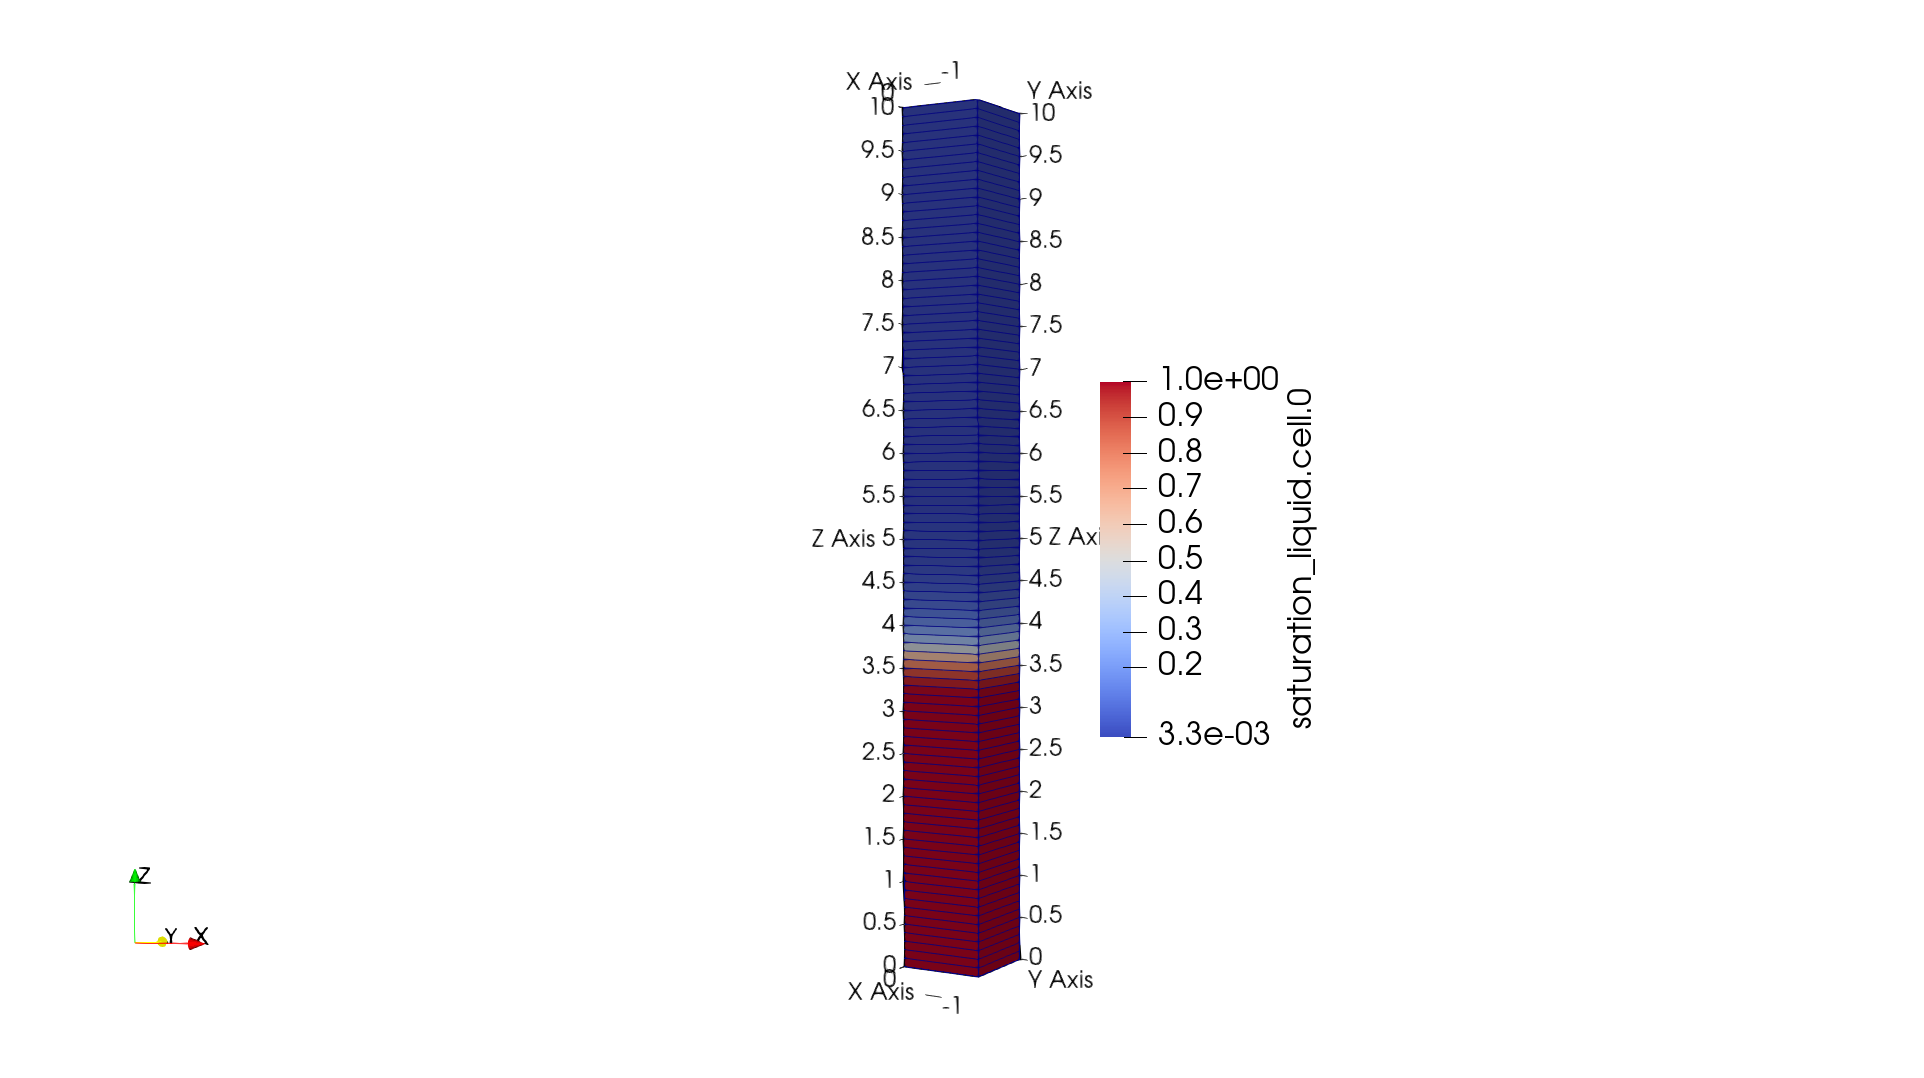

In [1]:
%matplotlib inline

In [2]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import plot_column_data
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def plot(dirname, title):
    """A generic plotting function that plots saturation as a function of depth."""
    fig = plt.figure()

    vis = ats_xdmf.VisFile(dirname, time_unit='d')
    vis.loadMesh(columnar=True)
    
    # plot the solution
    ax = fig.subplots(1,1)
    plot_column_data.plot_subsurface(vis, ['saturation_liquid',], ax, None, cmap='jet')
    ax.set_title(title)
    ax.set_xlabel('saturation [-]')
    ax.set_ylabel('z [m]')

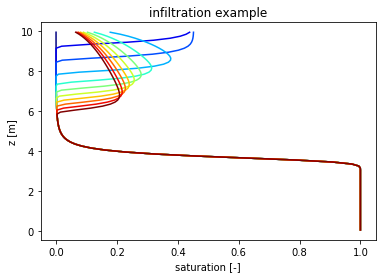

In [4]:
plot("./richards/run/", "infiltration example")

Text(0, 0.5, '$mol\\cdot m^{-2}\\cdot s^{-1}$')

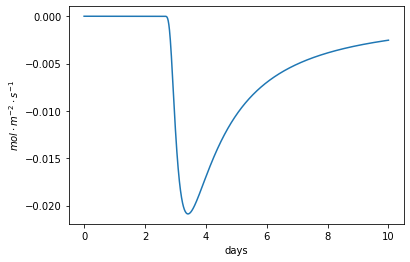

In [5]:
import numpy as np
from matplotlib import pyplot as plt

flux_data = np.loadtxt("./richards/run/observation_flux.dat",skiprows=11)
flux_data = np.transpose(flux_data)
fig = plt.figure()
ax = fig.subplots(1,1)
plt.plot(flux_data[0]/86400, flux_data[1])
ax.set_xlabel("days")
ax.set_ylabel(r"$mol\cdot m^{-2}\cdot s^{-1}$")


# Overland Flow (Diffusion Wave Equation)

Diffusion wave model for overland flow

$\newcommand{pondeddepth}{\delta_w}$
$\newcommand{watersource}{q_w}$
$\newcommand{flux}{{\bf U_w}}$
$\newcommand{manning}{n_{man}}$


$$
\begin{align}
  \frac{\partial \pondeddepth}{\partial t}  &+ \nabla \cdot \pondeddepth \flux = \watersource \\
  \flux &= -\displaystyle\frac{\pondeddepth^{2/3}}{\manning\left(||\nabla Z_s|| + \varepsilon\right)^{1/2}}
  \nabla\left(\nabla Z_s + \pondeddepth\right)
\end{align}
$$


$\pondeddepth$ - ponded depth
$\watersource$ - water source
$Z_s$ - surface elevation
$\manning$ - Manning’s coefficient


The test demonstrate rainfall event over hillslope domain with different boundary conditions. 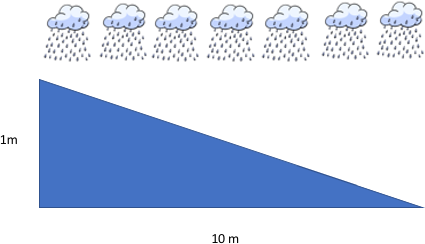

# Boundary conditions:

No-flow boundary condition:

    <ParameterList name="boundary conditions" type="ParameterList">
    </ParameterList>

Critical depth boundary conditions

this is an “outlet” boundary condition which looks to set an outward flux to take away runoff. This condition is given by condition on outward flux:

$$ q = \sqrt{g\hat z} n_{w} h^{3/2}$$

Example:

     <ParameterList name="boundary conditions" type="ParameterList">
        <ParameterList name="critical depth" type="ParameterList">
          <ParameterList name="outlet" type="ParameterList">
            <Parameter name="regions" type="Array(string)" value="{right side}" />
          </ParameterList>
        </ParameterList>
      </ParameterList>


Zero head gradient boundary conditions

This is an “outlet” boundary condition which looks to enforce the condition that

$$ \nabla \delta_w \cdot n = 0$$

Should be used only on boundaries where

$$ \nabla Z \cdot n  < 0 $$

Example:

      <ParameterList name="boundary conditions" type="ParameterList">
        <ParameterList name="zero gradient" type="ParameterList">
          <ParameterList name="outlet" type="ParameterList">
            <Parameter name="regions" type="Array(string)" value="{right side}" />
          </ParameterList>
        </ParameterList>
       </ParameterList> 

Max head or surface seepage boundary conditions.

if ${\bf U}_w\cdot n < 0$ then we set ${\bf U}_w\cdot n = 0$

if $\delta_w > \delta_{w,max}$ we set $\delta_w = \delta_{w,max}$


Example: 

     <ParameterList name="boundary conditions" type="ParameterList">
        <ParameterList name="seepage face head" type="ParameterList">
          <ParameterList name="outlet" type="ParameterList">
            <Parameter name="regions" type="Array(string)" value="{right side}" />
            <ParameterList name="boundary head" type="ParameterList">
              <ParameterList name="function-constant" type="ParameterList">
                <Parameter name="value" type="double" value="0.025" />
              </ParameterList>
            </ParameterList>
          </ParameterList>
        </ParameterList>
      </ParameterList>

## Integrated Hydrology